In [152]:
import os
import requests #HTTP library for Python
from urllib3.util.retry import Retry
from requests.adapters import HTTPAdapter
from urllib.parse import urljoin #combining URL components into a URL string
import json
import csv
from pathlib import Path
import yaml
import pandas as pd
import networkx as nx
from itertools import chain
from data_tools.files import download
from data_tools.plotting import count_plot_h, venn2_pretty, venn3_pretty
import matplotlib.pyplot as plt

In [24]:
analysis_path = Path(os. getcwd()).parent.joinpath('2_pipeline','6_query_metapaths','out',mp_index[2])
analysis_path.mkdir(parents=True, exist_ok=True)

In [7]:
SERVER_URL = "http://localhost:3000"

TIMEOUT = None

In [8]:
def path_to_tup(path):
    return (path['graph']['drugbank'], path['graph']['disease_mesh'])

def path_to_G(path):
    return nx.node_link_graph(path)       # Returns graph from node-link data format.                                                                                

def get_all_paths(path):
    source_id = path['links'][0]['source'] # drug id                                                                             
    target_ids = list(set([l['target'] for l in path['links']]) - set([l['source'] for l in path['links']])) # a-b 集合a中包含而集合b中不包含的元素
    # final target id
    G = path_to_G(path)
    this_paths = list(chain(*[list(nx.all_simple_paths(G, source_id, target_id)) for target_id in target_ids]))  #
    #Generate all simple paths in the graph G from source to target.
    # chain (*iterables)
    return this_paths

def get_id_to_type(G):
    id_to_type = {}
    for n in G.nodes.data():
        id_to_type[n[0]] = n[1]['label']
    return id_to_type

def get_id_to_name(G):
    id_to_name = {}
    for n in G.nodes.data():
        id_to_name[n[0]] = n[1]['name']
    return id_to_name

def add_metaedges(G): # export the simple relationship drug-decreases-disease such things
    id_to_type = get_id_to_type(G)
    for e in G.edges:
        G.edges[e]['metaedge'] = id_to_type[e[0]] + ' - ' + e[2] + ' - ' + id_to_type[e[1]]
    return G

def add_meanode_pairs(G): # export the simple relationship drug-disease such things
    id_to_type = get_id_to_type(G)
    for e in G.edges:
        G.edges[e]['mn_pair'] = id_to_type[e[0]] + ' - ' + id_to_type[e[1]]
    return G

def get_targets(G):
    drug = list(G.edges)[0][0]
    targets = []
    for e in G.edges:
        if e[0] == drug:
            targets.append(e[1])
    return targets

def get_target_metaedges(G):
    drug = list(G.edges)[0][0]
    target_mes = []
    if 'metaedge' not in G.edges[list(G.edges)[0]]:
        G = add_metaedges(G)
    
    for e in G.edges:
        if e[0] == drug:
            target_mes.append(G.edges[e]['metaedge'])
    return target_mes

In [9]:
# import csv generated from 1_code
basic_stats = pd.read_csv(Path(os. getcwd()).parent.joinpath('0_data','external','basic_stats.csv'))

In [10]:
basic_stats 

,Unnamed: 0,idx,id,drug,disease,n_nodes,n_edges,n_paths,longest_path,shortest_path,metapath,metapath_with_edges
0,0,0,DB00619_MESH_D015464_1,DB:DB00619,MESH:D015464,3,2,1,3,3,Drug - Protein - Disease,Drug - decreases activity of - Protein - cause...
1,1,1,DB00619_MESH_D034721_1,DB:DB00619,MESH:D034721,5,5,2,4,4,Drug - Protein - Protein - BiologicalProcess -...,Drug - decreases activity of - Drug - decrease...
2,2,2,DB00316_MESH_D010146_1,DB:DB00316,MESH:D010146,6,7,3,4,4,Drug - Protein - Protein - Pathway - ChemicalS...,Drug - decreases activity of - Drug - decrease...
3,3,3,DB00316_MESH_D005334_1,DB:DB00316,MESH:D005334,5,4,1,5,5,Drug - Pathway - GrossAnatomicalStructure - Bi...,Drug - negatively regulates - Pathway - occurs...
4,4,4,DB00945_MESH_D010146_1,DB:DB00945,MESH:D010146,5,5,2,4,4,Drug - Protein - Protein - ChemicalSubstance -...,Drug - decreases activity of - Drug - decrease...
...,...,...,...,...,...,...,...,...,...,...,...,...
3607,3607,3607,DB00863_MESH_D006356_1,DB:DB00863,MESH:D006356,5,4,1,5,5,Drug - Protein - BiologicalProcess - ChemicalS...,Drug - decreases activity of - Protein - posit...
3608,3608,3608,DB00863_MESH_D004415_1,DB:DB00863,MESH:D004415,6,5,1,6,6,Drug - Protein - BiologicalProcess - ChemicalS...,Drug - decreases activity of - Protein - posit...
3609,3609,3609,DB00863_MESH_D015043_1,DB:DB00863,MESH:D015043,6,5,1,6,6,Drug - Protein - BiologicalProcess - ChemicalS...,Drug - decreases activity of - Protein - posit...
3610,3610,3610,DB00989_MESH_D000544_1,DB:DB00989,MESH:D000544,6,6,2,5,5,Drug - Protein - ChemicalSubstance - Biologica...,Drug - decreases activity of - Drug - decrease...


In [11]:
mp_counts = pd.Series(basic_stats['metapath']).value_counts()
mp_index = mp_counts.head(20).index
mp_index

Index(['Drug - Protein - BiologicalProcess - BiologicalProcess - Disease',
       'Drug - Protein - BiologicalProcess - Disease', 'Drug - Disease',
       'Drug - Protein - BiologicalProcess - OrganismTaxon - Disease',
       'Drug - Protein - BiologicalProcess - BiologicalProcess - BiologicalProcess - Disease',
       'Drug - Protein - MolecularActivity - BiologicalProcess - Disease',
       'Drug - GeneFamily - BiologicalProcess - BiologicalProcess - CellularComponent - OrganismTaxon - Disease',
       'Drug - Protein - BiologicalProcess - PhenotypicFeature - Disease',
       'Drug - Protein - MolecularActivity - BiologicalProcess - BiologicalProcess - Disease',
       'Drug - Protein - Protein - Protein - Protein - ChemicalSubstance - BiologicalProcess - Disease',
       'Drug - Protein - BiologicalProcess - ChemicalSubstance - Disease',
       'Drug - BiologicalProcess - Disease',
       'Drug - GeneFamily - BiologicalProcess - OrganismTaxon - Disease',
       'Drug - ChemicalSubst

In [12]:
# Extract the indexes of each metapath
# basic_stats.loc[basic_stats ['metapath'] == 'Drug - Disease']
idxs = dict()
for idx, name in enumerate(mp_index):
    idxs[idx] = basic_stats.index[basic_stats ['metapath'] == name].tolist()

# Extract the indexes of each metapath
# basic_stats.loc[basic_stats ['metapath'] == 'Drug - Disease']

idx1 = basic_stats.index[basic_stats ['metapath'] == 'Drug - Protein - BiologicalProcess - BiologicalProcess - Disease'].tolist()
idx2 = basic_stats.index[basic_stats ['metapath'] == 'Drug - Protein - BiologicalProcess - Disease'].tolist()
idx3 = basic_stats.index[basic_stats ['metapath'] == 'Drug - Disease'].tolist()
idx4 = basic_stats.index[basic_stats ['metapath'] == 'Drug - Protein - BiologicalProcess - OrganismTaxon - Disease'].tolist()
idx5 = basic_stats.index[basic_stats ['metapath'] == 'Drug - Protein - BiologicalProcess - BiologicalProcess - BiologicalProcess - Disease'].tolist()
idx6 = basic_stats.index[basic_stats ['metapath'] == 'Drug - Protein - MolecularActivity - BiologicalProcess - Disease'].tolist()
idx7 = basic_stats.index[basic_stats ['metapath'] == 'Drug - GeneFamily - BiologicalProcess - BiologicalProcess - CellularComponent - OrganismTaxon - Disease'].tolist()
idx8 = basic_stats.index[basic_stats ['metapath'] == 'Drug - Protein - BiologicalProcess - PhenotypicFeature - Disease'].tolist()
idx9 = basic_stats.index[basic_stats ['metapath'] == 'Drug - Protein - MolecularActivity - BiologicalProcess - BiologicalProcess - Disease'].tolist()
idx10 = basic_stats.index[basic_stats ['metapath'] == 'Drug - Protein - Protein - Protein - Protein - ChemicalSubstance - BiologicalProcess - Disease'].tolist()

#Drug - Protein - BiologicalProcess - ChemicalSubstance - Disease                                           43
#Drug - BiologicalProcess - Disease                                                                         42
#Drug - GeneFamily - BiologicalProcess - OrganismTaxon - Disease                                            41
#Drug - ChemicalSubstance - Disease                                                                         38
#Drug - Protein - Protein - ChemicalSubstance - BiologicalProcess - Disease                                 37
#Drug - Protein - Pathway - BiologicalProcess - Disease                                                     30
#Drug - Protein - BiologicalProcess - BiologicalProcess - PhenotypicFeature - Disease                       29
#Drug - Protein - Protein - BiologicalProcess - Disease                                                     28
#Drug - Protein - BiologicalProcess - BiologicalProcess - OrganismTaxon - Disease                           27
#Drug - Protein - ChemicalSubstance - BiologicalProcess - Disease                                           25


### Import raw data 

In [13]:
data_dir = Path('../0_data/external').resolve()
with open(data_dir.joinpath('indication_paths.yaml'), 'r') as fh:
        ind = yaml.safe_load(fh)

### Template Test

In [145]:
column_names = ['idx', 'id', 'drug', 'disease', 'n_nodes', 'n_edges','shortest_path', 'metapath','metapath_with_edges','re-drug','re-disease','re-predicate',"retrieval"]
retable = pd.DataFrame(columns = column_names)
# Set the path 
template_path = Path(os. getcwd()).joinpath('query_templates',mp_index[2]+".json").resolve()
template_path
# Load the template from template_path 
with open(template_path) as f:
    template = json.load(f)

In [16]:
# Final loop
for m in idxs[2]:
    template["message"]["query_graph"]["nodes"]["n0"]["ids"] = ['DRUGBANK'+basic_stats.iat[m,3][2:]] 
    template["message"]["query_graph"]["nodes"]["n1"]["ids"] = [basic_stats.iat[m,4]] 
    doc = requests.post(urljoin(SERVER_URL, "/v1/query"), json=template, timeout=TIMEOUT)
    edges = doc.json()
    key = edges["message"]["knowledge_graph"]['edges'].keys()
    if list(key) !=[]:
        kg_edges = edges["message"]["knowledge_graph"]['edges'][list(key)[0]]
        retable.at[m,'re-drug'] = kg_edges['subject']
        retable.at[m,'re-disease'] = kg_edges['object']
        retable.at[m,'re-predicate'] = kg_edges['predicate']
        retable.at[m,'retrieval'] = 1
    else:
        retable.at[m,'retrieval'] = 0
        retable.at[m,'re-drug'] = basic_stats['drug'][m]
        retable.at[m,'re-disease'] = basic_stats['disease'][m]
        print("retrieval fails with" +basic_stats['drug'][m]+basic_stats['disease'][m])
        fail= fail+1

retrieval fails withDB:DB11254MESH:D014010
retrieval fails withDB:DB09389MESH:D015663
retrieval fails withDB:DBSALT001065MESH:D012393


In [17]:
# see the output 
retable.to_csv(str(analysis_path)+'/'+mp_index[2]+'.csv')
retable

,idx,id,drug,disease,n_nodes,n_edges,shortest_path,metapath,re-drug,re-disease,re-predicate,retrieval
60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PUBCHEM.COMPOUND:25223,MONDO:0005351,biolink:treats,1
69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PUBCHEM.COMPOUND:978,MONDO:0006594,biolink:treats,1
105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DB:DB11254,MESH:D014010,NaN,0
110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PUBCHEM.COMPOUND:247839,MONDO:0004577,biolink:treats,1
112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PUBCHEM.COMPOUND:247839,MONDO:0006604,biolink:treats,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PUBCHEM.COMPOUND:4744,MONDO:0005654,biolink:treats,1
3272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PUBCHEM.COMPOUND:54670067,MONDO:0006661,biolink:treats,1
3292,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PUBCHEM.COMPOUND:107526,MONDO:0004946,biolink:treats,1
3313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PUBCHEM.COMPOUND:6083,MONDO:0009061,biolink:treats,1


In [174]:
doc = requests.post(urljoin(SERVER_URL, "/v1/query"), json=template, timeout=TIMEOUT)

In [175]:
edges = doc.json()
key = edges["message"]["knowledge_graph"]['edges'].keys()
if list(key) !=[]:
    kg_edges = edges["message"]["knowledge_graph"]['edges'][list(key)[0]]
    kg_edges['subject']
    kg_edges['object']
    kg_edges['predicate']
else:
    print()

In [176]:
kg_edges['predicate']

{'predicate': 'biolink:approved_to_treat',
 'subject': 'PUBCHEM.COMPOUND:13109',
 'object': 'MONDO:0005351',
 'attributes': [{'attribute_type_id': 'biolink:aggregator_knowledge_source',
   'value': ['infores:biothings-explorer'],
   'value_type_id': 'biolink:InformationResource'},
  {'attribute_type_id': 'biolink:primary_knowledge_source',
   'value': ['infores:chembl'],
   'value_type_id': 'biolink:InformationResource'},
  {'attribute_type_id': 'biolink:aggregator_knowledge_source',
   'value': ['infores:mychem-info'],
   'value_type_id': 'biolink:InformationResource'},
  {'attribute_type_id': 'max_clinical_phase_for_indication', 'value': 3},
  {'attribute_type_id': 'reference_urls',
   'value': 'https://clinicaltrials.gov/search?id=%22NCT01343771%22'},
  {'attribute_type_id': 'source', 'value': 'ClinicalTrials'},
  {'attribute_type_id': 'year_first_approved', 'value': 1982}]}

In [223]:
kg_edges['predicate']

'biolink:approved_to_treat'

In [ ]:
# https://github.com/biolink/biolink-model/issues/398

### More complex test 'Drug - Protein - BiologicalProcess - Disease'

In [20]:
## test
test = 421
basic_stats.iloc[test,:]
# This is from the ymal file
drug_id, dis_id = path_to_tup(ind[test]) # extract the drug id and disease id
paths = get_all_paths(ind[test])
G = path_to_G(ind[test])
G = add_metaedges(G)
G = add_meanode_pairs(G)
print(drug_id, dis_id)
print(paths)
print(paths[0][1][-7:])
print(paths[0][2][-8:])

DB:DB00543 MESH:D003866
[['MESH:D000657', 'UniProt:P21728', 'GO:0051584', 'MESH:D003866']]
:P21728
:0051584


In [122]:
column_names = ['idx', 'id', 'drug','protein','bio', 'disease', 'n_nodes', 'n_edges','shortest_path', 'metapath','metapath_with_edges','re-drug','re-protein','re-bio','re-disease',"retrieval"]
retable = pd.DataFrame(columns = column_names)
# Set the path 
template_path = Path(os. getcwd()).joinpath('query_templates',mp_index[1]+".json").resolve()
template_path
# Load the template from template_path 
with open(template_path) as f:
    template = json.load(f)
lst = []
for pos,char in enumerate(mp_index[1]):
    if(char == '-'):
        lst.append(pos)

In [127]:
# Final loop
#for m in idxs[1]:
for m in idxs[1]:
    paths = get_all_paths(ind[m])
    ymal_node_list = [str(paths[0][0]),'UniProtKB'+str(paths[0][1][-7:]),'GO'+str(paths[0][2][-8:]),str(paths[0][3])]
    template["message"]["query_graph"]["nodes"]["n0"]["ids"] = [str(paths[0][0])]
    template["message"]["query_graph"]["nodes"]["n1"]["ids"] = ['UniProtKB'+str(paths[0][1][-7:])] 
    template["message"]["query_graph"]["nodes"]["n2"]["ids"] = ['GO'+str(paths[0][2][-8:])] 
    template["message"]["query_graph"]["nodes"]["n"+str(len(lst))]["ids"] = [str(paths[0][3])]
    doc = requests.post(urljoin(SERVER_URL, "/v1/query"), json=template, timeout=TIMEOUT)
    retable.at[m,'id'] = m
    retable.at[m,'drug'] = str(paths[0][0])
    retable.at[m,'protein'] ='UniProtKB'+str(paths[0][1][-7:])
    retable.at[m,'bio'] ='GO'+str(paths[0][2][-8:])
    retable.at[m,'disease'] = str(paths[0][3])
    retable.at[m,'n_nodes']=basic_stats.iat[m,5]
    retable.at[m,'n_edges']=basic_stats.iat[m,6]
    retable.at[m,'shortest_path']=basic_stats.iat[m,9]
    retable.at[m,'metapath']=basic_stats.iat[m,10]
    retable.at[m,'metapath_with_edges']=basic_stats.iat[m,11]
    if doc.status_code == 200: 
        edges = doc.json()
        key = edges["message"]["knowledge_graph"]['edges'].keys()
        if list(key) !=[]:
            try:
                edges['error']
            except:
                #kg_edges = edges["message"]["knowledge_graph"]['edges'][list(key)[0]]
                bte_node_list =edges["message"]["knowledge_graph"]['nodes'].keys()
                for eachnode in list(bte_node_list):
                    node_biolink = edges["message"]["knowledge_graph"]['nodes'][eachnode]['categories'][0][8:]
                    dismatch =0
                    if node_biolink == 'SmallMolecule':
                        if ymal_node_list[0] in edges["message"]["knowledge_graph"]['nodes'][eachnode]['attributes'][0]['value']:
                            retable.at[m,'re-drug'] = ymal_node_list[0]
                        else:
                            print("drug not match")
                            dismatch = dismatch+1
                    if node_biolink == 'Gene':
                        if ymal_node_list[1] in edges["message"]["knowledge_graph"]['nodes'][eachnode]['attributes'][0]['value']:
                            retable.at[m,'re-protein'] = ymal_node_list[1]
                        else:
                            print("protein not match")
                            dismatch = dismatch+1
                    if node_biolink == 'BiologicalProcess':
                        if ymal_node_list[2] in edges["message"]["knowledge_graph"]['nodes'][eachnode]['attributes'][0]['value']:
                            retable.at[m,'re-bio'] = ymal_node_list[2]
                        else:
                            print("BiologicalProcess not match")
                            dismatch = dismatch+1
                    if node_biolink == 'Disease':
                        if ymal_node_list[3] in edges["message"]["knowledge_graph"]['nodes'][eachnode]['attributes'][0]['value']:
                            retable.at[m,'re-disease'] = ymal_node_list[3]   
                        else:
                            print("Disease not match")
                            dismatch = dismatch+1
                if dismatch ==0:
                    retable.at[m,'retrieval'] = 1 # retrieved successfully and matched
                    print("retrieval succeeds and matched with" +basic_stats['drug'][m]+basic_stats['disease'][m])
                else: 
                    retable.at[m,'retrieval'] = 3 # retrieved successfully and dismatched
                    print("retrieval succeeds with" +basic_stats['drug'][m]+basic_stats['disease'][m]+'but mismatch!')
            else:
                print("Error!"+ edges['error']+basic_stats['drug'][m]+basic_stats['disease'][m])
                retable.at[m,'retrieval'] = 2
                retable.at[m,'re-drug'] = basic_stats['drug'][m]
                retable.at[m,'re-disease'] = basic_stats['disease'][m]
        else:
            retable.at[m,'retrieval'] = 0
            retable.at[m,'re-drug'] = basic_stats['drug'][m]
            retable.at[m,'re-disease'] = basic_stats['disease'][m]
            print("retrieval fails with" +basic_stats['drug'][m]+basic_stats['disease'][m])
    else: 
        retable.at[m,'retrieval'] = -1
        retable.at[m,'re-drug'] = basic_stats['drug'][m]
        retable.at[m,'re-disease'] = basic_stats['disease'][m]
        print ( "BTE timed out"+" retrieval fails with" +basic_stats['drug'][m]+basic_stats['disease'][m])

retrieval fails withDB:DB08799MESH:D012223
retrieval fails withDB:DB00748MESH:D003233
retrieval fails withDB:DB00066MESH:D016649
retrieval fails withDB:DB09046MESH:D008060
retrieval succeeds withDB:DB00455MESH:D065631
retrieval fails withDB:DB00935MESH:D015508
retrieval fails withDB:DB00476MESH:D003865
retrieval succeeds withDB:DB00366MESH:D065631
retrieval fails withDB:DB00996MESH:D012148
retrieval fails withDB:DB12770MESH:D005764
retrieval fails withDB:DB12212MESH:D013610
retrieval fails withDB:DB01106MESH:D003233
retrieval fails withDB:DB00524MESH:D006973
retrieval fails withDB:DB12184MESH:D003865
retrieval fails withDB:DB00193MESH:D010146
retrieval fails withDB:DB00347MESH:D004832
retrieval fails withDB:DB01437MESH:D007319
retrieval fails withDB:DB00568MESH:D014717
retrieval fails withDB:DB00568MESH:D014717
retrieval fails withDB:DB09010MESH:D003110
retrieval fails withDB:DB05812MESH:D011471
retrieval fails withDB:DB00285MESH:D016584
retrieval fails withDB:DB00285MESH:D016584
retri

In [156]:
retable.to_csv(str(analysis_path.parent)+'/'+mp_index[1]+'.csv')
retable.head()

,idx,id,drug,protein,bio,disease,n_nodes,n_edges,shortest_path,metapath,metapath_with_edges,re-drug,re-protein,re-bio,re-disease,retrieval
19,NaN,19,MESH:D000865,UniProtKB:P35367,GO:0034776,MESH:D012223,4,3,4,Drug - Protein - BiologicalProcess - Disease,Drug - decreases activity of - Protein - parti...,DB:DB08799,NaN,NaN,MESH:D012223,0
30,NaN,30,MESH:C004649,UniProtKB:P35367,GO:0034776,MESH:D003233,4,3,4,Drug - Protein - BiologicalProcess - Disease,Drug - decreases activity of - Protein - posit...,DB:DB00748,NaN,NaN,MESH:D003233,0
31,NaN,31,MESH:D005640,UniProtKB:P23945,GO:0030728,MESH:D016649,4,3,4,Drug - Protein - BiologicalProcess - Disease,Drug - increases activity of - Protein - posit...,DB:DB00066,NaN,NaN,MESH:D016649,0
35,NaN,35,MESH:C415771,UniProtKB:P48357,GO:0060612,MESH:D008060,4,3,4,Drug - Protein - BiologicalProcess - Disease,Drug - increases activity of - Protein - regul...,DB:DB09046,NaN,NaN,MESH:D008060,0
37,NaN,37,MESH:D017336,UniProtKB:P35367,GO:0034776,MESH:D065631,4,3,4,Drug - Protein - BiologicalProcess - Disease,Drug - decreases activity of - Protein - parti...,MESH:D017336,UniProtKB:P35367,GO:0034776,MESH:D065631,1


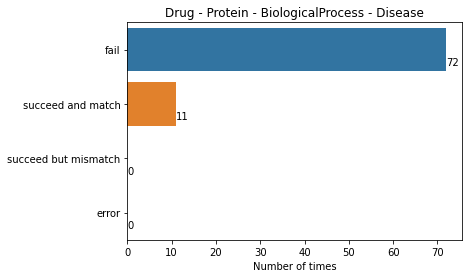

In [165]:
output = {'succeed and match': retable[retable['retrieval']==1].shape[0], 'succeed but mismatch': retable[retable['retrieval']==3].shape[0],'fail': retable[retable['retrieval']==0].shape[0],'error': retable[retable['retrieval']==2].shape[0]}
output = pd.Series(data=output, index=['succeed and match',"succeed but mismatch", 'fail',"error"])
count_plot_h(output)
plt.title(str(mp_index[1]))
plt.xlabel('Number of times');

In [166]:
edges

{'workflow': [{'id': 'lookup'}],
 'message': {'query_graph': {'nodes': {'n0': {'categories': ['biolink:SmallMolecule'],
     'ids': ['MESH:D004298']},
    'n1': {'categories': ['biolink:Protein', 'biolink:Gene'],
     'ids': ['UniProtKB:P08588']},
    'n2': {'categories': ['biolink:BiologicalProcess'], 'ids': ['GO:0060048']},
    'n3': {'categories': ['biolink:Disease'], 'ids': ['MESH:D002303']}},
   'edges': {'e01': {'subject': 'n0', 'object': 'n1'},
    'e02': {'subject': 'n1', 'object': 'n2'},
    'e03': {'subject': 'n2', 'object': 'n3'}}},
  'knowledge_graph': {'nodes': {}, 'edges': {}},
  'results': []},
 'logs': [{'timestamp': '2022-04-13T22:05:47.807Z',
   'level': 'WARNING',
   'message': 'The following APIs were unavailable at the time of execution: Connections Hypothesis Provider API',
   'code': None},
  {'timestamp': '2022-04-13T22:05:48.700Z',
   'level': 'DEBUG',
   'message': 'BTE identified 4 qNodes from your query graph',
   'code': None},
  {'timestamp': '2022-04-13T2

### Next step 
1. Test other pairs
2. drug and disease: to test 